In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from ultralytics.data.utils import visualize_image_annotations
from ultralytics import YOLO
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 5]

# Data exploration and preparation
Inspect train data and its annotation

In [2]:
# Dataset size
image_files = os.listdir('../datasets/Drone_TrainSet_100Snippet')
image_files_len = len(image_files)
image_files_len

100

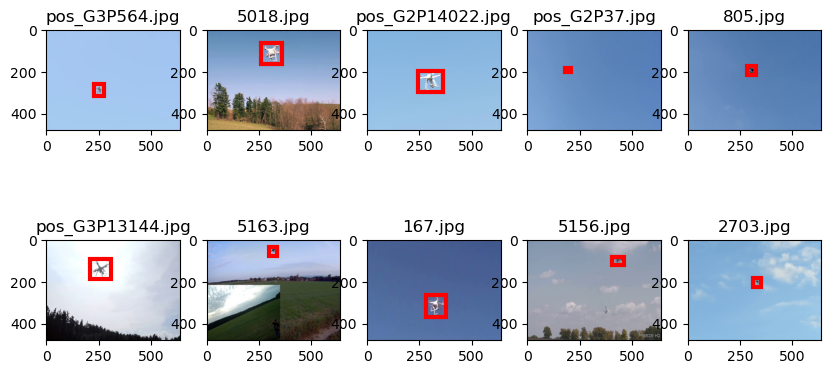

In [3]:
# get 10 random images from dataset
idx = random.sample(range(image_files_len), 10)
fig, ax = plt.subplots(nrows=2, ncols=5)

def get_bounding_box_from_xml(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  xmin = root.find('object').find('bndbox').find('xmin').text
  ymin = root.find('object').find('bndbox').find('ymin').text
  xmax = root.find('object').find('bndbox').find('xmax').text
  ymax = root.find('object').find('bndbox').find('ymax').text

  x = int(xmin)
  y = int(ymin)
  width = int(xmax) - x
  height = int(ymax) - y
  return (x, y, width, height)


for i in range(5):
  id_1 = i * 2
  id_2 = i * 2 + 1

  img_1_path = image_files[idx[id_1]]
  img_2_path = image_files[idx[id_2]]

  img_1 = cv2.imread('../datasets/Drone_TrainSet_100Snippet/' + img_1_path)
  img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
  img_2 = cv2.imread('../datasets/Drone_TrainSet_100Snippet/' + img_2_path)
  img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

  img_1_xml = '../datasets/Drone_TrainSet_XMLs_100Snippet/' + img_1_path.replace('jpg', 'xml')
  x, y, width, height = get_bounding_box_from_xml(img_1_xml)
  rect_1 = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
  plt.subplot(2, 5, id_1 + 1), plt.title(img_1_path), ax[0][i].imshow(img_1), ax[0][i].add_patch(rect_1)

  img_2_xml = '../datasets/Drone_TrainSet_XMLs_100Snippet/' + img_2_path.replace('jpg', 'xml')
  x, y, width, height = get_bounding_box_from_xml(img_2_xml)
  rect_2 = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
  plt.subplot(2, 5, id_2 + 1), plt.title(img_2_path), ax[1][i].imshow(img_2), ax[1][i].add_patch(rect_2)


Transform drone detection dataset from original to COCO format (compatible with YOLO).

In [4]:
!python ../utils/convert_drone_detection_dataset_to_yolo_format.py --train-input ../datasets/Drone_TrainSet_100Snippet/ --annotation-input ../datasets/Drone_TrainSet_XMLs_100Snippet/ --train-output ../datasets/drone_detection_yolo --test-input ../datasets/Drone_TestSet_100Snippet --test-annotation-input ../datasets/Drone_TestSet_XMLs_100Snippet

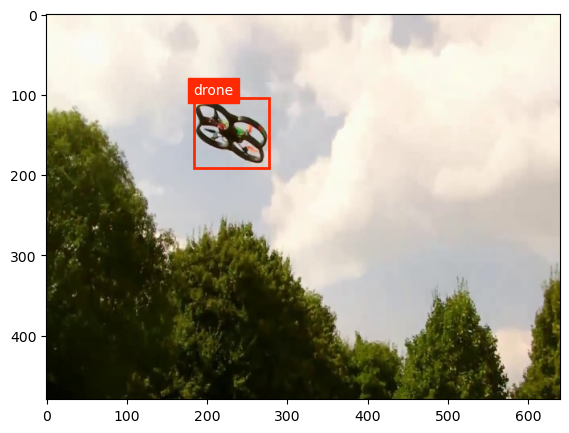

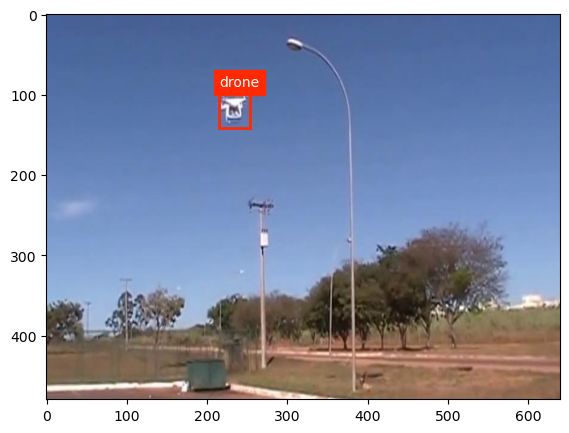

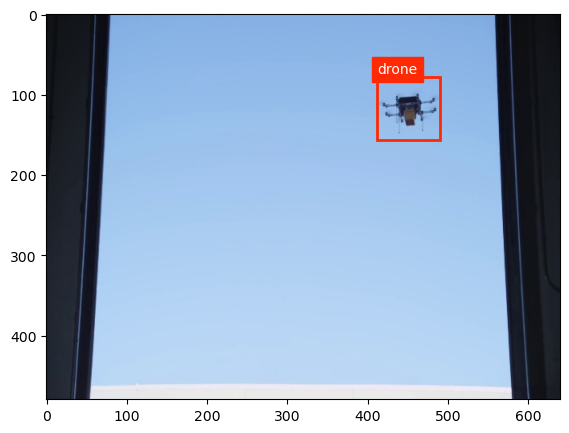

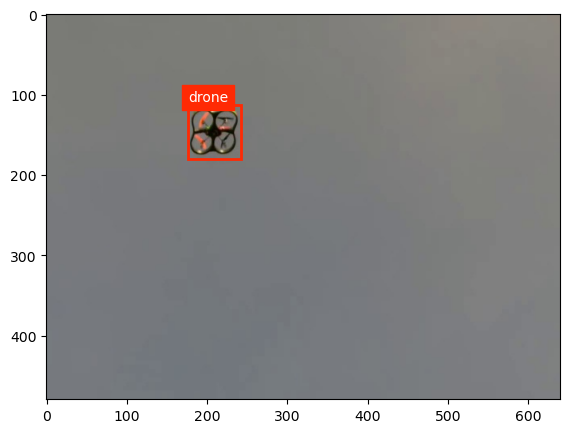

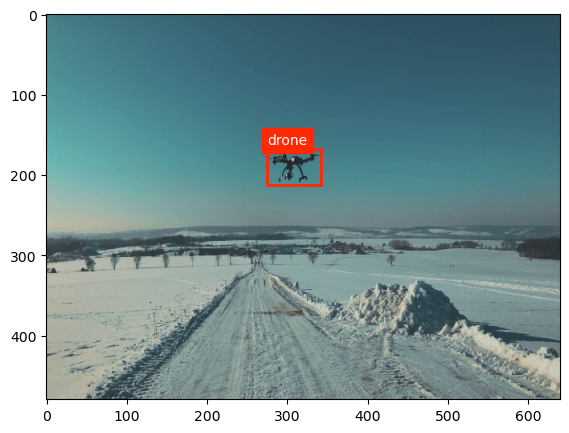

In [5]:
image_files = os.listdir('../datasets/drone_detection_yolo/images/train')
image_files_len = len(image_files)
label_map = { 0: "drone" }

# get 5 random images from dataset
idx = random.sample(range(image_files_len), 5)

for i in range(5):
  img_path = '../datasets/drone_detection_yolo/images/train/' + image_files[idx[i]]
  img_label = img_path.replace('images', 'labels').replace('jpg', 'txt')
  visualize_image_annotations(img_path, img_label, label_map)

In [6]:
# get size of samples
img = cv2.imread('../datasets/drone_detection_yolo/images/train/1007.jpg')
print(f"Width - {img.shape[1]}, height - {img.shape[0]}")

Width - 640, height - 480


# Detection
## Train model for detection task

In [20]:
model = YOLO("yolo11n.yaml")
results = model.train(
    data='../datasets/drone_detection_yolo/drone_detection_yolo.yaml',
    epochs=50,
    save=True,
    batch=-1,
    single_cls=True
)

Ultralytics 8.3.223 🚀 Python-3.13.9 torch-2.6.0 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/drone_detection_yolo/drone_detection_yolo.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train38, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

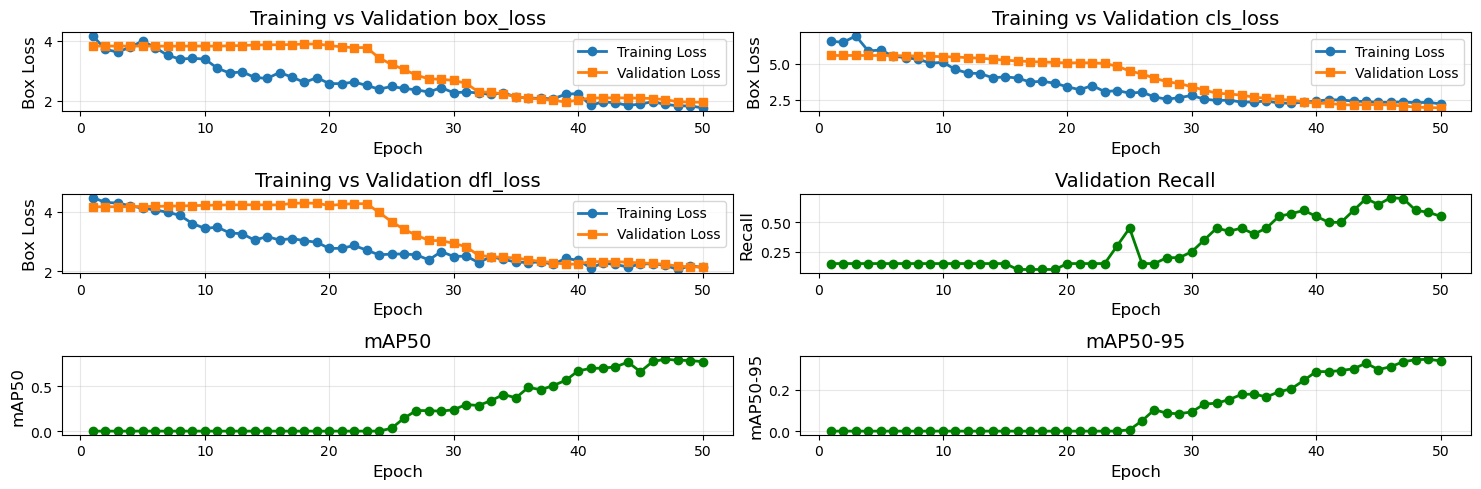

In [21]:
df = pd.read_csv('runs/detect/train38/results.csv')
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(nrows=3, ncols=2, figsize=(15, 5))

# Subplot 1: Training and Validation box_loss
ax1.plot(df['epoch'], df['train/box_loss'], marker='o', label='Training Loss', linewidth=2)
ax1.plot(df['epoch'], df['val/box_loss'], marker='s', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Box Loss', fontsize=12)
ax1.set_title('Training vs Validation box_loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Training and Validation cls_loss
ax2.plot(df['epoch'], df['train/cls_loss'], marker='o', label='Training Loss', linewidth=2)
ax2.plot(df['epoch'], df['val/cls_loss'], marker='s', label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Box Loss', fontsize=12)
ax2.set_title('Training vs Validation cls_loss', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Subplot 3: Training and Validation dfl_loss
ax3.plot(df['epoch'], df['train/dfl_loss'], marker='o', label='Training Loss', linewidth=2)
ax3.plot(df['epoch'], df['val/dfl_loss'], marker='s', label='Validation Loss', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Box Loss', fontsize=12)
ax3.set_title('Training vs Validation dfl_loss', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Validation Recall
ax4.plot(df['epoch'], df['metrics/recall(B)'], marker='o', color='green', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Validation Recall', fontsize=14)
ax4.grid(True, alpha=0.3)

# Subplot 5: mAP50
ax5.plot(df['epoch'], df['metrics/mAP50(B)'], marker='o', color='green', linewidth=2)
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('mAP50', fontsize=12)
ax5.set_title('mAP50', fontsize=14)
ax5.grid(True, alpha=0.3)

# Subplot 6: mAP50-95
ax6.plot(df['epoch'], df['metrics/mAP50-95(B)'], marker='o', color='green', linewidth=2)
ax6.set_xlabel('Epoch', fontsize=12)
ax6.set_ylabel('mAP50-95', fontsize=12)
ax6.set_title('mAP50-95', fontsize=14)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
val = model.val(plots=True, conf=0.01)

Ultralytics 8.3.223 🚀 Python-3.13.9 torch-2.6.0 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1208.7±631.6 MB/s, size: 34.5 KB)
val: Scanning /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/datasets/drone_detection_yolo/labels/val.cache... 20 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 40.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.4it/s 1.5s3.8s
                   all         20         20      0.921      0.585      0.784      0.351
Speed: 1.2ms preprocess, 67.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/runs/detect/val11


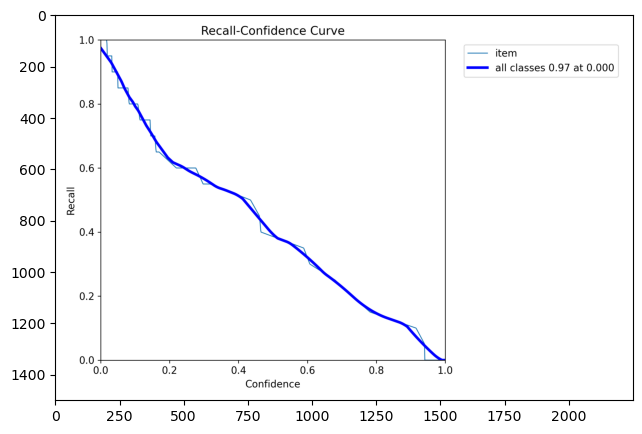

In [23]:
box_r_curve = mpimg.imread('runs/detect/val11/BoxR_curve.png')
plt.imshow(box_r_curve)

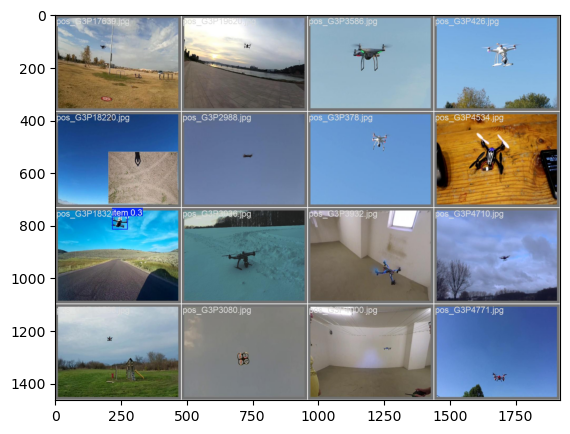

In [24]:
pred_img = mpimg.imread('runs/detect/val10/val_batch0_pred.jpg')
plt.imshow(pred_img)

In [25]:
results = model.predict(
    source='../datasets/drone_detection_yolo/images/val',
    conf=0.1,  # Low threshold to see all detections
    save=True,
    imgsz=640
)


image 1/20 /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/../datasets/drone_detection_yolo/images/val/pos_G3P17639.jpg: 480x640 1 item, 111.2ms
image 2/20 /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/../datasets/drone_detection_yolo/images/val/pos_G3P18220.jpg: 480x640 1 item, 83.9ms
image 3/20 /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/../datasets/drone_detection_yolo/images/val/pos_G3P18324.jpg: 480x640 2 items, 87.5ms
image 4/20 /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/../datasets/drone_detection_yolo/images/val/pos_G3P18596.jpg: 480x640 3 items, 90.6ms
image 5/20 /home/dzhere/Documents/side-projects/fpv-drone-tracking-detection-depth-estimation/notebooks/../datasets/drone_detection_yolo/images/val/pos_G3P19620.jpg: 480x640 1 item, 91.4ms
image 6/20 /home/dzhere/Documents/side-projects/fpv